In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path(os.getcwd()).parent)
print(Path().cwd())

/Users/wuyuanshan/Desktop/Github/QuantUS-Plugins-CEUS/TwoD_CEUS_test
/Users/wuyuanshan/Desktop/Github/QuantUS-Plugins-CEUS


## Select Contrast-Enhanced Ultrasound (CEUS) Cine and Parser

In [2]:
from src.image_loading.options import get_scan_loaders

print("Available scan loaders:", list(get_scan_loaders().keys()))

Available scan loaders: ['avi', 'nifti', 'custom_dicom', 'mp4']


In [3]:
scan_type = 'mp4'

scan_path = '/Users/wuyuanshan/Desktop/Research/Post-Doc El Kaffas/ctDNA Project Samantha/Data/wk6/p14_wk6.mp4'
scan_loader_kwargs = {
    'transpose': False
}

In [4]:
from src.entrypoints import scan_loading_step

image_data = scan_loading_step(scan_type, scan_path, **scan_loader_kwargs)

In [5]:
# import matplotlib.pyplot as plt
# import cv2
import numpy as np

# single_image = image_data.pixel_data[100,:,:,0]
# plt.imshow(single_image,cmap='gray')
# print(image_data.pixel_data.shape)

# # Reshape the data and store into the image_data
temp = image_data.pixel_data[:,:,:,0]
image_data.pixel_data = temp
print(image_data.pixel_data.shape)

(826, 1472, 1962)


## Load Segmentation

Assumes same segmentation for each frame

In [6]:
from src.seg_loading.options import get_seg_loaders

print("Available segmentation loaders:", list(get_seg_loaders().keys()))

Available segmentation loaders: ['nifti', 'load_bolus_mask']


In [7]:
seg_type = 'nifti'

seg_path = '/Users/wuyuanshan/Desktop/Research/Post-Doc El Kaffas/ctDNA Project Samantha/Data/wk6/p14_wk6_mc_roi.nii.gz'
seg_loader_kwargs = {}

In [8]:
from src.entrypoints import seg_loading_step

seg_data = seg_loading_step(seg_type, image_data, seg_path, scan_path, **seg_loader_kwargs)

In [9]:
# #transpose
seg_data.seg_mask = seg_data.seg_mask.transpose(2, 1, 0)   
print(seg_data.seg_mask.shape)
print(image_data.pixel_data.shape)


(826, 1472, 1962)
(826, 1472, 1962)


In [10]:
#Use inline backend - MORE RELIABLE for Jupyter
# %matplotlib inline
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.ndimage import binary_erosion
# from IPython.display import clear_output
# import time
# def get_mask_boundary(mask_slice):
#     """Extract boundary of a binary mask using erosion."""
#     if mask_slice.max() == 0:
#         return np.zeros_like(mask_slice, dtype=bool)
#     eroded = binary_erosion(mask_slice)
#     boundary = mask_slice.astype(bool) & ~eroded
#     return boundary
# print(f"Image shape: {image_data.pixel_data.shape}")
# print(f"Mask shape: {seg_data.seg_mask.shape}")

# # Frame range
# num_frames = image_data.pixel_data.shape[-1]
# start_frame = 0
# end_frame = min(num_frames, 300)
# print(f"Visualizing frames {start_frame} to {end_frame}")
# print("Starting animation...\n")
# # Loop through frames
# for frame in range(start_frame, end_frame):
#     # Clear previous output and display current frame
#     clear_output(wait=True)
#     # Create figure for this frame
#     fig, axes = plt.subplots(figsize=(18, 6))
#     # === AXIAL VIEW ===
#     axial_img = image_data.pixel_data[frame, :,  :]
#     axial_mask = seg_data.seg_mask[frame]
#     axial_boundary = get_mask_boundary(axial_mask)
#     axes.imshow(axial_img, cmap='gray')
#     axes.contour(axial_boundary, colors='red', linewidths=2)
#     axes.set_xlabel('Lateral (X)')
#     axes.set_ylabel('Depth (Y)')
    
#     # Add overall frame counter
#     fig.suptitle(f'Frame {frame}/{end_frame-1}', fontsize=16, fontweight='bold')
#     plt.tight_layout()
#     plt.show()
#     # Print progress
#     print(f"Frame {frame}/{end_frame-1}")
#     # Pause
#     time.sleep(0.01)
#     # Close figure to save memory
#     plt.close(fig)

## CEUS Quantitative Temporal Curve Analysis

In [11]:
from src.time_series_analysis.options import get_analysis_types, get_required_kwargs

all_analysis_types, all_analysis_funcs = get_analysis_types()
print("Available analysis types:", list(all_analysis_types.keys()))
print("Available analysis functions:", list(all_analysis_funcs.keys()))

Available analysis types: ['curves_paramap', 'curves']
Available analysis functions: ['pyradiomics', 'tic']


In [12]:
analysis_type = 'curves_paramap'
analysis_funcs = ['tic']

# Find all required kwargs for the analysis functions
analysis_funcs = analysis_funcs if len(analysis_funcs) else list(all_analysis_funcs[analysis_type].keys())
required_kwargs = get_required_kwargs(analysis_type, analysis_funcs)
print("Required kwargs for current analysis:", required_kwargs)

Required kwargs for current analysis: ['cor_vox_ovrlp', 'ax_vox_len', 'cor_vox_len', 'sag_vox_ovrlp', 'ax_vox_ovrlp', 'sag_vox_len']


In [13]:
analysis_kwargs = {
    'ax_vox_ovrlp': 0,  # %
    'sag_vox_ovrlp': 0,  # %
    'cor_vox_ovrlp': 0,  # %
    'ax_vox_len': 50.0,  # mm
    'sag_vox_len': 50.0,  # mm
    'cor_vox_len': 50.0,  # mm
    'curves_output_path': '', # don't export the curves we generate
}

In [14]:
print(seg_data.seg_mask.shape)
print(image_data.intensities_for_analysis.shape)
print(image_data.pixel_data.shape)

(826, 1472, 1962)
(826, 1472, 1962)
(826, 1472, 1962)


In [15]:
from src.entrypoints import analysis_step

analysis_obj = analysis_step(analysis_type, image_data, seg_data, analysis_funcs, **analysis_kwargs)

Computing curves: 100%|██████████| 826/826 [01:06<00:00, 12.49it/s]


In [16]:
# analysis_obj.verify_motion_compensated_windows(start_frame=0, end_frame=692,coverage_threshold= 0.2, save_path= "window_check.gif")

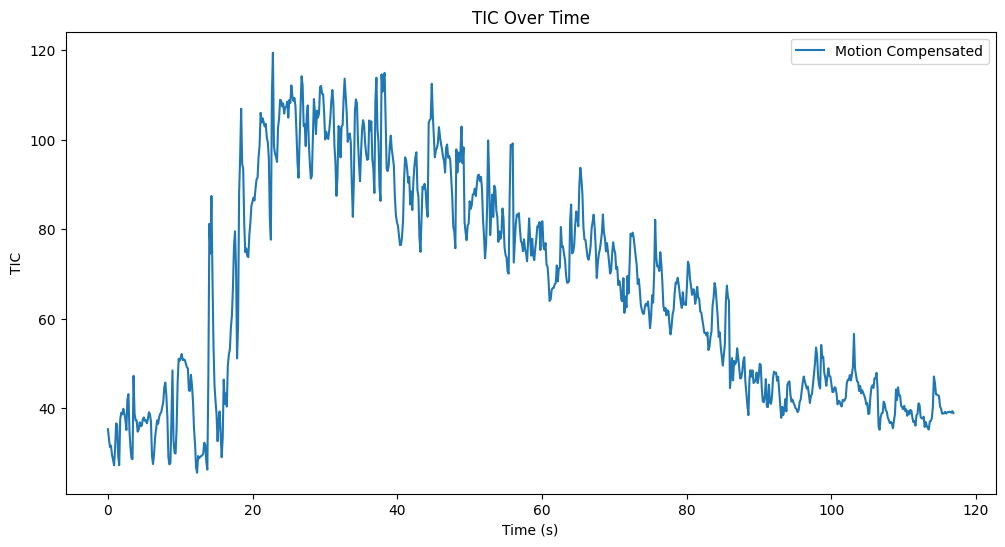

In [17]:
import matplotlib.pyplot as plt
# Create a figure with a specific size (e.g., 8 inches wide, 6 inches tall)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(analysis_obj.time_arr,analysis_obj.curves[4]['TIC'], label='Motion Compensated')
ax.set_xlabel('Time (s)')
ax.set_ylabel('TIC')
ax.set_title('TIC Over Time')
ax.legend()
plt.show()

## Curve Quantification

In [18]:
from src.curve_quantification.options import get_quantification_funcs

quantification_funcs = get_quantification_funcs()
print("Available quantification functions:", quantification_funcs.keys())

Available quantification functions: dict_keys(['auc_no_fit', 'cmus_firstorder', 'dte', 'first_order_full', 'first_order_select', 'lognormal_fit_full', 'lognormal_fit_select', 'wash_rates'])


In [19]:
function_names = ['lognormal_fit_full'] # Empty list will use all functions
output_path = '/Users/wuyuanshan/Desktop/Research/Post-Doc El Kaffas/ctDNA Project Samantha/Data/wk6'
output_path += "/curve.csv"
curve_quantifications_kwargs = {
    'curves_to_fit': ['TIC'],
}

In [20]:
from src.entrypoints import curve_quantification_step

curve_quant = curve_quantification_step(analysis_obj, function_names, output_path, **curve_quantifications_kwargs)

['lognormal_fit_full']
Ordered functions: ['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFICATIONS FUNCTIONS
['lognormal_fit_full']
IN COMPUTER_QUANTIFI

In [21]:
curve_quant.data_dict

[{'Scan Name': 'p14_wk6',
  'Segmentation Name': 'p14_wk6_mc_roi',
  'Window-Axial Start Pix': 332,
  'Window-Sagittal Start Pix': 275,
  'Window-Axial End Pix': 382,
  'Window-Sagittal End Pix': 325,
  'AUC_full_TIC': np.float64(58.53300951028053),
  'PE_full_TIC': np.float64(0.8517617086043846),
  'TP_full_TIC': np.float64(28.693321815937082),
  'MTT_full_TIC': np.float64(63.99663720976503),
  'T0_full_TIC': np.float64(8.28512898861502),
  'Mu_full_TIC': np.float64(3.8914418277042047),
  'Sigma_full_TIC': np.float64(0.7312847744587369),
  'PE_Ix_full_TIC': np.int64(261)},
 {'Scan Name': 'p14_wk6',
  'Segmentation Name': 'p14_wk6_mc_roi',
  'Window-Axial Start Pix': 332,
  'Window-Sagittal Start Pix': 325,
  'Window-Axial End Pix': 382,
  'Window-Sagittal End Pix': 375,
  'AUC_full_TIC': np.float64(81.87777888564453),
  'PE_full_TIC': np.float64(0.9508436606132481),
  'TP_full_TIC': np.float64(27.71455931791298),
  'MTT_full_TIC': np.float64(83.59271619694401),
  'T0_full_TIC': np.flo

## Parametric Map Visualizations

In [22]:
from src.visualizations.options import get_visualization_types

types, funcs = get_visualization_types()
print("Available visualization types:", list(types.keys()))
print("Available visualization functions:", list(funcs.keys()))

Available visualization types: ['paramap']
Available visualization functions: ['paramap']


In [48]:
vis_type = 'paramap'
params = [] # Empty list will use all parameters 
vis_funcs = []
vis_kwargs = {
    'paramap_folder_path': '/Users/wuyuanshan/Desktop/Research/Post-Doc El Kaffas/ctDNA Project Samantha/Data/wk6',
    'hide_all_visualizations': False,  # Set to True to hide all visualizations
}

In [50]:
from src.entrypoints import visualization_step

vis_obj = visualization_step(curve_quant, vis_type, params, vis_funcs, **vis_kwargs)

In [55]:
print(np.nanmax(vis_obj.numerical_paramaps[0]))

116.287865


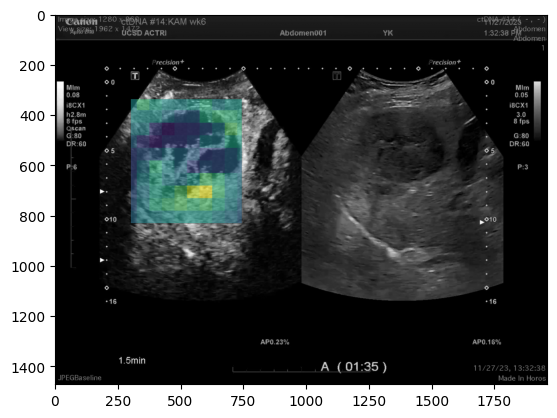

In [56]:
import numpy as np
import matplotlib.pyplot as plt
frame = 500
plt.imshow(image_data.pixel_data[frame], cmap='gray')

disp_map = vis_obj.numerical_paramaps.copy()

use_gamma = False      # <--- toggle this to False to disable
gamma = 1.5

if use_gamma:
    disp_map = np.power(disp_map, 1.0 / gamma, where=~np.isnan(disp_map))

plt.imshow(disp_map[0], vmin=0, vmax=120, alpha=0.6)